### Group -3 
#### Control Theory Course Project
### Topic- Modelling PID Controller for autonomus cars
Group Members- ROll No. 31,38,50,51

### Content- 
1. Controlling sterring angle of a car using 

    a] P controller

    b] PD controller
    
    c] PID controller

<img src="https://media.istockphoto.com/photos/cockpit-of-futuristic-autonomous-car-picture-id971246808?k=20&m=971246808&s=612x612&w=0&h=QX1k9qK4L5PhZ-f4VozojarzqJTqwVLXkeu8NBHsMFQ=">

## Car Class


In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class Car(object):
    def __init__(self, x=0.0, y=0.0, orientation=0.0, length=20.0):
        self.x = x
        self.y = y
        self.orientation = orientation
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    """
    Sets car coordinate.
    """
    def set(self, x, y, orientation): 
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        # Makes it possible to change the noise parameters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        self.steering_drift = drift

    """
    steering = front wheel steering angle, limited by max_steering_angle
    distance = total distance driven, most be non-negative
    """
    def move(self, steering, speed, delta_t=1.0, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if speed < 0.0:
            speed = 0.0

        actual_steering = random.gauss(steering, self.steering_noise)
        actual_distance = random.gauss(speed*delta_t, self.distance_noise) 

        actual_steering += self.steering_drift

        turn_angle = np.tan(actual_steering) * actual_distance / self.length

        if abs(turn_angle) < tolerance:
            self.x += actual_distance * np.cos(self.orientation)
            self.y += actual_distance * np.sin(self.orientation)
            self.orientation = (self.orientation + turn_angle) % (2.0 * np.pi)
        else:
            radius = actual_distance / turn_angle
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn_angle) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)  

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

In [11]:
Car()

[x=0.00000 y=0.00000 orient=0.00000]

<img src="C://Users//ADMIN//Frame.png">

## P Controller
The Proportional term determines how hard the car will turn towards its desired trajectory.

$steer(t) = - K_p * e_p(t)$


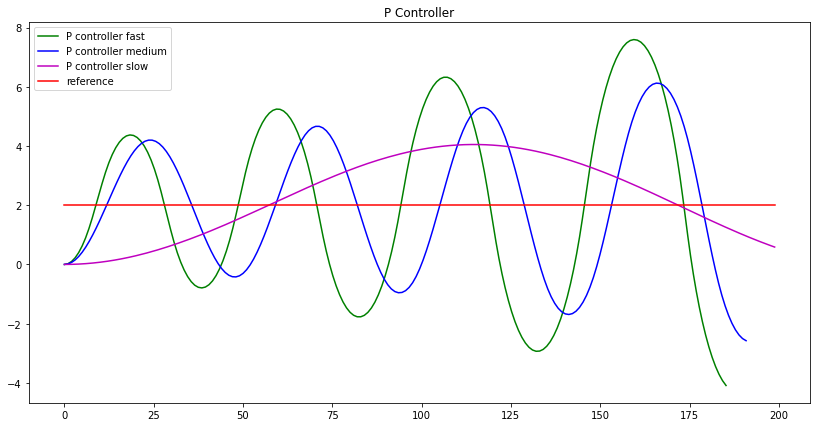

In [12]:
car = Car(x=0, y=0, orientation=0)


def run_pcontroller(car, kp, desired_out=2.0, step_size=1.0, num_steps=1, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []

    desired_y = desired_out       # DESIRED Y VALUE
    for i in range(n):
        if (i % (n // num_steps) == 0 and i > 0):
            desired_y += step_size

        x_trajectory.append(car.x)
        y_trajectory.append(car.y)
        desired_y_trajectory.append(desired_y)
        
        # Update values
        total_error = car.y - desired_y_trajectory[-1]
        car.move(-kp * total_error, speed)
    
    return x_trajectory, y_trajectory, desired_y_trajectory

kp_fast = 0.8
kp_med = 0.3
kp_slow = 0.015

plt.figure(figsize=(14,7))

car = Car(x=0, y=0, orientation=0)
x_traj_f, y_traj_f, _ = run_pcontroller(car, kp_fast)
plt.plot(x_traj_f, y_traj_f, 'g', label='P controller fast')

car = Car(x=0, y=0, orientation=0)
x_traj_med, y_traj_med, _ = run_pcontroller(car, kp_med)
plt.plot(x_traj_med, y_traj_med, 'b', label='P controller medium')

car = Car(x=0, y=0, orientation=0)
x_traj_slow, y_traj_slow, desired_y_trajectory = run_pcontroller(car, kp_slow)
plt.plot(x_traj_slow, y_traj_slow, 'm', label='P controller slow')

plt.plot(x_traj_slow, desired_y_trajectory, 'r', label='reference')
plt.title("P Controller")
plt.legend()
plt.show()


## PD Controller
The Derivative term determines how much the car will resist changes in its position.


$steer(t) = - K_p * e_p(t) - K_d * e_d(t)$

$e_d(t) = e_{p}(t) - e_{p}(t-1)$



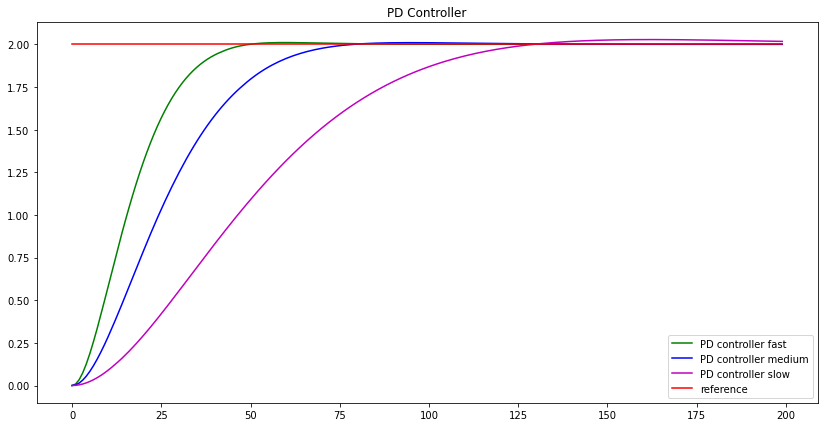

In [13]:
def run_pdcontroller(car, kp, kd, initial_step=2.0, step_size=2.0, num_steps=1, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []
    
    desired_y = initial_step
    prev_ep = car.y - desired_y # previous proportional error
    for i in range(n):
        if (i % (n // num_steps) == 0 and i > 0):
            desired_y += step_size
        
        x_trajectory.append(car.x)
        y_trajectory.append(car.y)
        desired_y_trajectory.append(desired_y)
        
        # Update values
        total_error = car.y - desired_y_trajectory[-1]
        steer = (-kp * total_error) + (-kd * (total_error - prev_ep))  
        car.move(steer, speed)
        prev_ep = total_error
        
    return x_trajectory, y_trajectory, desired_y_trajectory

# Fast
kp_fast = 0.17
kd_fast = 3.0
# Medium
kp_med = 0.073
kd_med = 2.0
# Slow
kp_slow = 0.02
kd_slow = 1.0

plt.figure(figsize=(14,7))

car = Car(x=0, y=0, orientation=0)
x_traj_f, y_traj_f, _ = run_pdcontroller(car, kp_fast, kd_fast)
plt.plot(x_traj_f, y_traj_f, 'g', label='PD controller fast')

car = Car(x=0, y=0, orientation=0)
x_traj_med, y_traj_med, _ = run_pdcontroller(car, kp_med, kd_med)
plt.plot(x_traj_med, y_traj_med, 'b', label='PD controller medium')

car = Car(x=0, y=0, orientation=0)
x_traj_slow, y_traj_slow, desired_y_trajectory = run_pdcontroller(car, kp_slow, kd_slow)
plt.plot(x_traj_slow, y_traj_slow, 'm', label='PD controller slow')

plt.plot(x_traj_slow, desired_y_trajectory, 'r', label='reference')
plt.title("PD Controller")

plt.legend()
plt.show()

## Implement PID Controller

Implement the PID controller below

$steer(t) = - K_p * e_p(t) - K_d * e_d(t) - K_i * e_i(t)$

$e_d(t) = e_{p}(t) - e_{p}(t-1)$

$e_i(t) = \displaystyle\sum_{t}e_p(t)$


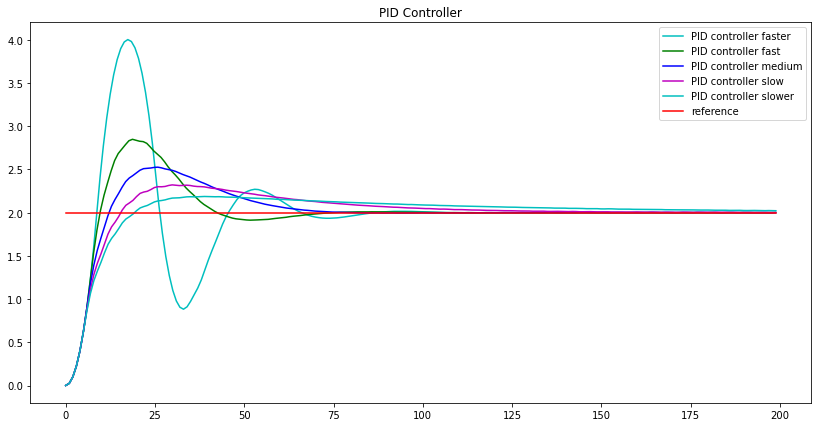

In [14]:
car = Car(x=0, y=0, orientation=0)

car.set_noise(1,1)
car.set_steering_drift(10)


def run_pidcontroller(car, kp, kd, ki, initial_step=2.0, step_size=2.0, num_steps=1, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []
    
    desired_y = initial_step
    prev_ep = car.y - desired_y 
    sum_ep_diff = 0 
    ei = 0 
    for i in range(n):
        if (i % (n // num_steps) == 0 and i > 0):
            desired_y += step_size

        x_trajectory.append(car.x)
        y_trajectory.append(car.y)
        desired_y_trajectory.append(desired_y)
        

        total_error = car.y - desired_y_trajectory[-1]
        sum_ep_diff += total_error
        ei += (total_error + prev_ep) / 2

        steer = -1 * (kp*total_error + kd*(total_error - prev_ep) + ki*ei) 
        car.move(steer, speed)
        prev_ep = total_error
        
    return x_trajectory, y_trajectory, desired_y_trajectory

kp = 4.0
kd = 29
# Faster
kp_faster = kp
kd_faster = kd
ki_faster = 0.8
# Fast
kp_fast = kp
kd_fast = kd
ki_fast = 0.4
# Medium
kp_med = kp
kd_med = kd
ki_med = 0.2
# Slow
kp_slow = kp
kd_slow = kd
ki_slow = 0.1
# Slower
kp_slower = kp
kd_slower = kd
ki_slower = 0.05

plt.figure(figsize=(14,7))

car = Car(x=0, y=0, orientation=0)
x_traj_faster, y_traj_faster, _ = run_pidcontroller(car, kp_faster, kd_faster, ki_faster)
plt.plot(x_traj_faster, y_traj_faster, 'c', label='PID controller faster')

car = Car(x=0, y=0, orientation=0)
x_traj_fast, y_traj_fast, _ = run_pidcontroller(car, kp_fast, kd_fast, ki_fast)
plt.plot(x_traj_fast, y_traj_fast, 'g', label='PID controller fast')

car = Car(x=0, y=0, orientation=0)
x_traj_med, y_traj_med, _ = run_pidcontroller(car, kp_med, kd_med, ki_med)
plt.plot(x_traj_med, y_traj_med, 'b', label='PID controller medium')

car = Car(x=0, y=0, orientation=0)
x_traj_slow, y_traj_slow, _ = run_pidcontroller(car, kp_slow, kd_slow, ki_slow)
plt.plot(x_traj_slow, y_traj_slow, 'm', label='PID controller slow')

car = Car(x=0, y=0, orientation=0)
x_traj_slower, y_traj_slower, desired_y_trajectory = run_pidcontroller(car, kp_slower, kd_slower, ki_slower)
plt.plot(x_traj_slower, y_traj_slower, 'c', label='PID controller slower')

plt.plot(x_traj_slow, desired_y_trajectory, 'r', label='reference')
plt.title("PID Controller")
plt.legend()
plt.show()